In [1]:
%pylab inline
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib.pyplot import imread, quiver, quiverkey
from scipy.ndimage import map_coordinates, sobel
from scipy.spatial.distance import cdist
from scipy.io import loadmat

Populating the interactive namespace from numpy and matplotlib


### images

In [2]:
notre_dame = imread('data/Notre Dame/1_o.jpg')
notre_dame2 = imread('data/Notre Dame/2_o.jpg')
features = loadmat('data/Notre Dame/f_o.mat')
notre_dame_f = np.hstack((features['x1'], features['y1']))
notre_dame2_f = np.hstack((features['x2'], features['y2']))

### Visualizators

In [3]:
def pol2cart(rho, phi):
    x = rho * np.cos(np.deg2rad(phi))
    y = rho * np.sin(np.deg2rad(phi))
    return x, y

def plot_quiver(ax, hist, bins, scale=1, n=None, color=None):
    if n is None:
        n = len(hist)
    x, y = pol2cart(hist, bins)
    if color is not None:
        ax.quiver(np.zeros(n), np.zeros(n), x[:n], y[:n], units='xy', scale=scale, color=c)
    else:
        ax.quiver(np.zeros(n), np.zeros(n), x[:n], y[:n], units='xy', scale=scale)
    

### globals

In [4]:
PATCH_R = 20
PAD_SIZE = PATCH_R*2 + 1
BIN_N = 36
BIN_SIZE = 360/BIN_N
DOMINANT_ANGLE_PEAK_TRESHOLD = 0.7

### Image preprocesing functions

In [5]:
def rgb2y(img):
    return img.dot(np.array([ 0.2989,  0.5866,  0.1145]))

def normalize(img):
    return img / img.max()

def extract_rotate(pos, angle, scale, R):
    pos = np.array(pos)
    th = np.deg2rad(-angle)
    M = np.array([np.cos(th), -np.sin(th), np.sin(th), np.cos(th)]).reshape((2,2)) * scale
    def rotate(data):
        off = data - R
        off = np.einsum("ab,xb->xa", M, off)  # M[:, None, :].dot(off.T)[:, 0, :].T - broadcast dot product
        return pos + off
    return rotate
    

def img_transform(source_image, function, target_shape=None, constant=0, order=3, mode='constant'):
    if target_shape is None:
        target_shape = source_image.shape
    cx,cy = np.meshgrid(np.arange(target_shape[0]), np.arange(target_shape[1]))
    coords = np.stack((cx,cy), axis=2).reshape((-1,2), order='F')
    coords2 = np.fliplr(function(np.fliplr(coords)))
    assert coords.shape == coords2.shape, ("Original coords shape %s is not equal to modified coords shape %s." % (coords.shape, coords2.shape))
    pts = map_coordinates(source_image, coords2.T, order=order, mode=mode, cval=constant)
    pts = pts.T
    tshape = (target_shape[1], target_shape[0])
    pts = pts.reshape(tshape, order='F').transpose((1,0))
    return pts.copy()

def extract_patch(img, pos, angle=0, scale=1, R=PATCH_R):
    x, y = map(int, pos)
    if np.abs(angle) < 1 and scale==1:
        sl = (slice(y-R, y+R+1), slice(x-R, x+R+1))
        return img[sl]
    return img_transform(img, extract_rotate(pos, angle, scale, R), target_shape=(R*2 + 1, R*2 + 1))

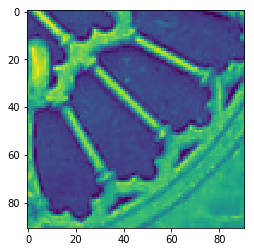

In [6]:
imshow(extract_patch(rgb2y(notre_dame), [850, 1250], R=45))

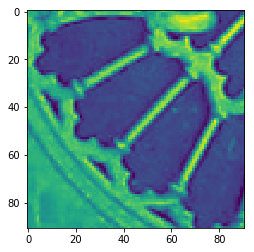

In [7]:
imshow(extract_patch(rgb2y(notre_dame), [850, 1250], 90, 1, 45))

### Kernel generators

In [11]:
def kernel_gen(sigma, R):
    def kernel(data):
        data = data - R
        dist = (data**2).sum(axis=1)
        return np.exp(-(dist)/(2 * (sigma**2)))
    return kernel

def img_gen(function, target_shape):
    cx, cy = np.meshgrid(np.arange(target_shape[0]), np.arange(target_shape[1]))
    coords = np.stack((cx,cy), axis=2).reshape((-1,2), order='F')
    pts = function(np.fliplr(coords))
    assert coords.shape[0] == pts.shape[0], ("Original coords shape %s is not mathching samples shape %s." % (coords.shape, pts.shape))
    tshape = (target_shape[1], target_shape[0], target_shape[2])
    pts = pts.reshape(tshape, order='F').transpose((1,0,2))
    return pts.copy()

def gaussian_kernel(sigma):
    return img_gen(kernel_gen(sigma, PATCH_R), (PATCH_R*2+1,PATCH_R*2+1,1))[..., 0]

# Task 1 - Compute dominant orientation of features

In [12]:
def dominant_orientation(mag, angle, feature):    
    x, y, scale = feature

    patch_mag = extract_patch(mag, [x,y])
    patch_angle = extract_patch(angle, [x,y])

    weights = gaussian_kernel(scale * 10.) * patch_mag

    # Compute histogram
    _range = (-180., 180.)
    hist, bins = np.histogram(a=patch_angle, bins=BIN_N, range=_range, weights=weights, density=False)
    bins = (bins[:-1] + bins[1:]) / 2.
    hist_s = np.argsort(hist)
    return hist[hist_s][::-1], bins[hist_s][::-1]


def compute_features_dominant_orientation(image, features):
    # Convert image to intensity and normalize to [0, 1]
    I = normalize(rgb2y(image))

    # Add padding around I
    I = np.pad(I, ((PAD_SIZE,PAD_SIZE),(PAD_SIZE,PAD_SIZE)), mode='edge')
    features += np.array([PAD_SIZE, PAD_SIZE, 0])
    # Compute gradients
    dY = sobel(I,axis=0,mode='reflect')
    dX = sobel(I,axis=1,mode='reflect')
    
    # Compute magnitude
    mag = np.sqrt(dX**2+dY**2)
    # Compute angle
    angle = np.rad2deg(np.arctan2(dY, dX))
    
    return [dominant_orientation(mag=mag, angle=angle, feature=f) for f in features]

### Plot feature, gradient and quiver

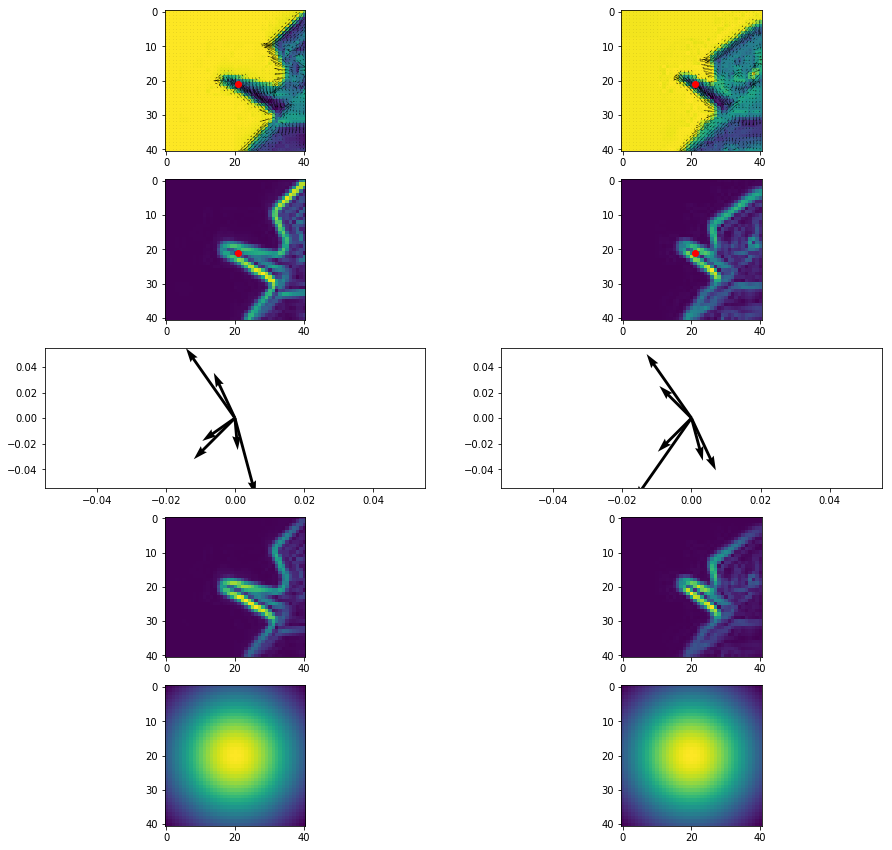

In [9]:
n_feature = 4
s=15.
I1 = rgb2y(notre_dame)
I1 = extract_patch(I1, notre_dame_f[n_feature])

dY1 = sobel(normalize(I1),axis=0,mode='reflect')
dX1 = sobel(normalize(I1),axis=1,mode='reflect')

# magnitude
mag1 = np.hypot(dY1,dX1)
# angle
angle1 = np.rad2deg(np.arctan2(dY1, dX1))

weights1 = gaussian_kernel(1 * s) * mag1

# Compute histogram
_range = (-180., 180.)
hist, bins = np.histogram(a=angle1, bins=BIN_N, range=_range, weights=weights1, density=False)
hist_s = np.argsort(hist)
bins = (bins[:-1] + bins[1:]) / 2.
hist1, bins1 = hist[hist_s][::-1], bins[hist_s][::-1]


I2 = rgb2y(notre_dame2)
I2 = extract_patch(I2, notre_dame2_f[n_feature])

dY2 = sobel(normalize(I2),axis=0,mode='reflect')
dX2 = sobel(normalize(I2),axis=1,mode='reflect')

# magnitude
mag2 = np.hypot(dY2,dX2)
# angle
angle2 = np.rad2deg(np.arctan2(dY2, dX2))

weights2 = gaussian_kernel(1 * s) * mag2

# Compute histogram
_range = (-180, 180)
hist, bins = np.histogram(a=angle2, bins=BIN_N, range=_range, weights=weights2, density=False)
hist_s = np.argsort(hist)
bins = (bins[:-1] + bins[1:]) / 2.
hist2, bins2 = hist[hist_s][::-1], bins[hist_s][::-1]


# --------------------------------------------------------------
# plot
fig = figure(figsize=(15, 15))
ax = fig.subplots(5, 2)

x, y = np.mgrid[0:41, 0:41]

ax[0,0].imshow(I1)
ax[0,0].quiver(x, y, dX1.T, dY1.T)
ax[0,0].scatter(21,21,color='r')
ax[1,0].imshow(mag1)
ax[1,0].scatter(21,21,color='r')
plot_quiver(ax[2,0], hist1, bins1, n=6, scale=1200)
ax[3,0].imshow(weights1)
ax[4,0].imshow(gaussian_kernel(1 * s))


ax[0,1].imshow(I2)
ax[0,1].quiver(x, y, dX2.T, dY2.T)
ax[0,1].scatter(21,21,color='r')
ax[1,1].imshow(mag2)
ax[1,1].scatter(21,21,color='r')
plot_quiver(ax[2,1], hist2, bins2, n=6, scale=1200)
ax[3,1].imshow(weights2)
ax[4,1].imshow(gaussian_kernel(1 * s))

In [13]:
r1 = compute_features_dominant_orientation(notre_dame, [(x, y, 1.) for x, y in notre_dame_f])
r2 = compute_features_dominant_orientation(notre_dame2, [(x, y, 1.) for x, y in notre_dame2_f])

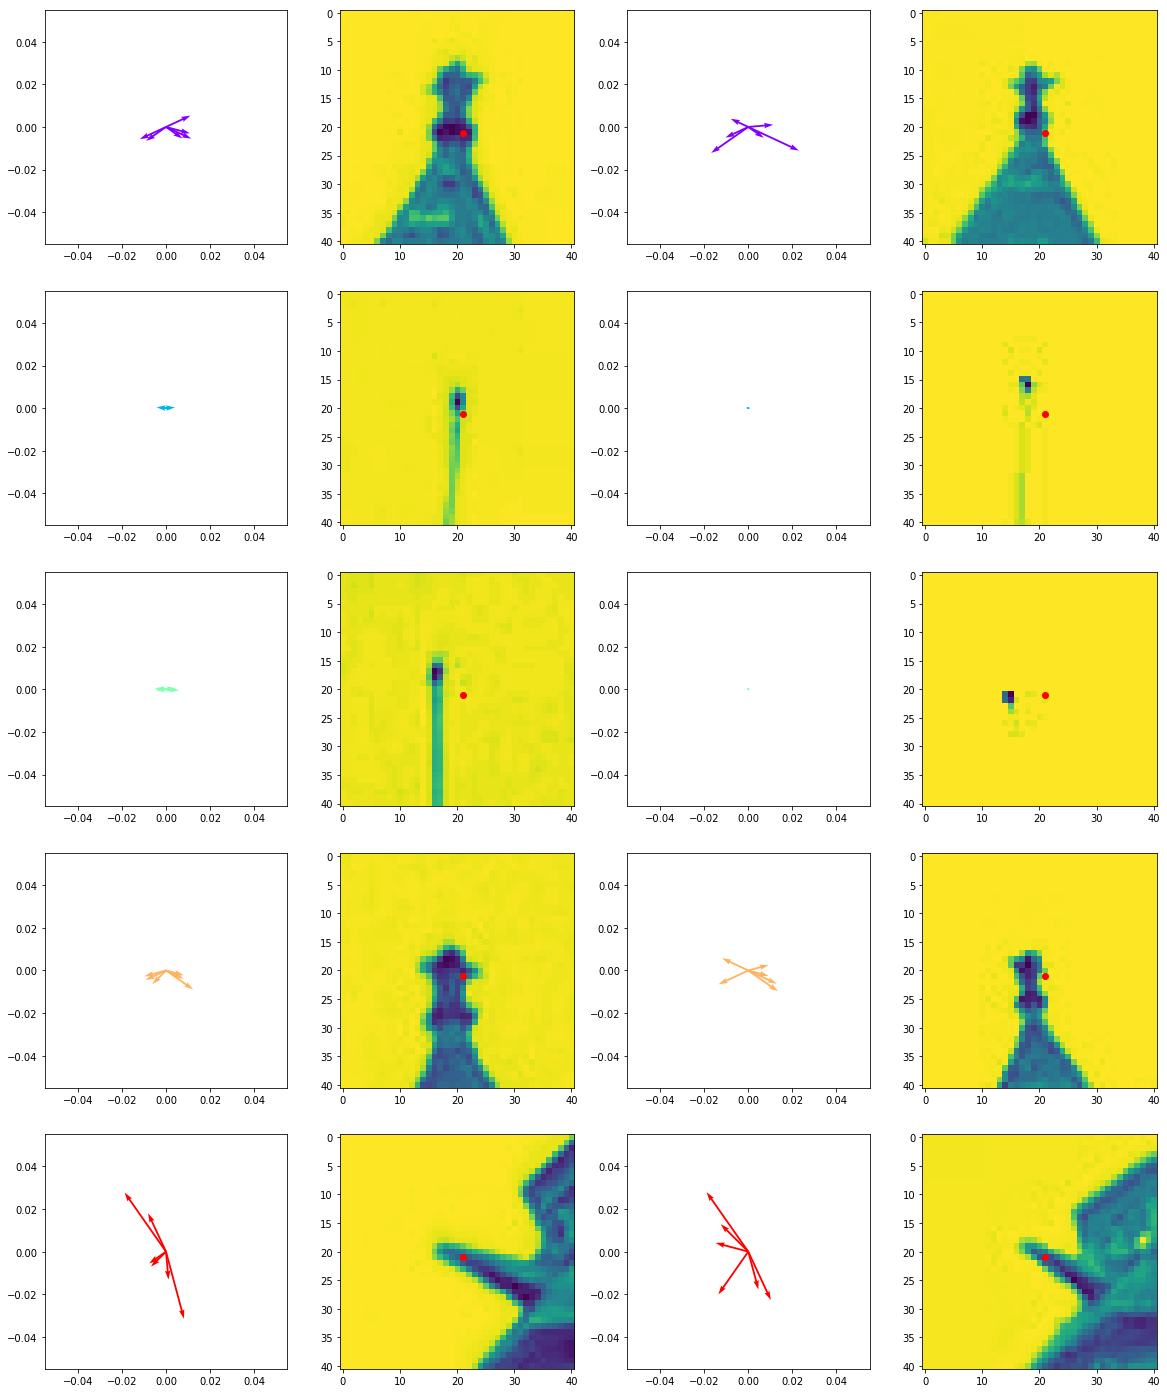

In [14]:
n = 5
fig = figure(figsize=(20, 25))
ax = fig.subplots(n, 4)
colors = cm.rainbow(np.linspace(0, 1, n))
for i, ((h1, b1), (h2, b2), c)  in enumerate(zip(r1[:n], r2[:n], colors)):
    plot_quiver(ax[i, 0], h1, b1, n=6, scale=1000, color=c)
    ax[i, 1].imshow(extract_patch(rgb2y(notre_dame), notre_dame_f[i]))
    ax[i, 1].scatter(21, 21, color='r')
    plot_quiver(ax[i, 2], h2, b2, n=6, scale=1000, color=c)
    ax[i, 3].imshow(extract_patch(rgb2y(notre_dame2), notre_dame2_f[i]))
    ax[i, 3].scatter(21, 21, color='r')
# plt.axis('equal')

# Task 2 - Feature descriptors

In [17]:
def feature_descriptor(image, feature, angle, kernel16, i=0):
    x, y, scale = feature
    patch16 = extract_patch(image, [x,y], angle, scale, R=8)[:16, :16]

    dY16 = sobel(patch16,axis=0,mode='reflect')
    dX16 = sobel(patch16,axis=1,mode='reflect')
    
    mag16 =  np.sqrt(dX16**2+dY16**2)
    angle16 =  np.rad2deg(np.arctan2(dY16, dX16))

    # Smoothing weights
    magn16 = mag16 * kernel16

    d = []
    for Qy in [0,1,2,3]:
        for Qx in [0,1,2,3]:
            sy = slice(4*Qy, 4*Qy + 4)
            sx = slice(4*Qx, 4*Qx + 4)
            Qmagn16 = magn16[sy,sx]
            Qangle16 = angle16[sy,sx]
            Qhist, _ = np.histogram(Qangle16, 8, (-180, 180), weights=Qmagn16, density=False)
            d += list(Qhist)

    assert(len(d) == 128)
    d = np.asarray(d)
    d = d/d.max();
    d[d > 0.2] = 0.2
    d = d/d.max();
    return np.hstack([[i, x-PAD_SIZE, y-PAD_SIZE, scale, angle], d])
    
def compute_features_descriptors(image, features):
    # Convert image to intensity and normalize to [0, 1]
    I = normalize(rgb2y(image))
    
    #     Add padding around I
    I = np.pad(I, ((PAD_SIZE,PAD_SIZE),(PAD_SIZE,PAD_SIZE)), mode='edge')
    features += np.array([PAD_SIZE, PAD_SIZE, 0])
    
    # compute gradient
    dY = sobel(I,axis=0,mode='reflect')
    dX = sobel(I,axis=1,mode='reflect')
    
    # compute magnitude
    mag = np.sqrt(dX**2+dY**2)
    
    # compute angle
    angle = np.rad2deg(np.arctan2(dY, dX))
    
    # smoothing kernel
    kernel16 = img_gen(kernel_gen(4., 8), (16,16,1))[:,:,0]
    
    # compute histograms and bins
    histograms = [dominant_orientation(mag=mag, angle=angle, feature=f) for f in features]
    
    # compute dominant angles and descriptors
    descriptors = []
    for i, ((hist, bins), f) in enumerate(zip(histograms, features)):
        dominant_angles = bins[hist[0] * DOMINANT_ANGLE_PEAK_TRESHOLD <= hist]
        descriptors += [feature_descriptor(image=I, feature=f, angle=a, kernel16=kernel16, i=i) for a in dominant_angles]
        
    descriptors = np.asarray(descriptors)
    print descriptors.shape
    return descriptors

In [18]:
# features1 = [(x, y, 1.5) for y, x in p1]
desc1 = compute_features_descriptors(notre_dame, [(x, y, 1) for x, y in notre_dame_f])

# features2 = [(x, y, 1.5) for y, x in p2]
desc2 = compute_features_descriptors(notre_dame2, [(x, y, 1) for x, y in notre_dame2_f])

(523, 133)
(570, 133)


# Task 3: Matching using NNDR

In [69]:
def prepare_results(d1, d2):
    # compute distances
    dist = cdist(d1[:, 6:], d2[:, 6:], 'euclidean')
    # take nearest neighbor for each feature
    C = d2[np.argmin(dist, 1)]
    # take two nearest distances
    vals = np.sort(dist, 1)[:,:2]
    # return data frame with combined results
    df = pd.DataFrame(np.hstack((d1[:,:5], C[:,:5], vals[:,0,None], vals[:,1,None])),
                      columns=['idx', 'x1', 'y1', 's1', 'a1', 'idx2', 'x2', 'y2', 's2', 'a2', 'val1', 'val2'])
    return df

In [95]:
def nndr(df, ratio=0.85):
    # compute nearest neighbor distance ratio
    df['ratio'] = df.val1 / df.val2
    # remove values with ratio greater than 0.85
    df = df.loc[df.ratio < ratio]
    # select best candidates by distance for each remining feature
    return df.loc[df.groupby('idx')['val1'].idxmin()]

### print results

number of all features:  149
positive:  35
score for all features:  23.48993288590604 %

number of filtered features by NNDR:  22
positive:  16
score:  72.72727272727273 %


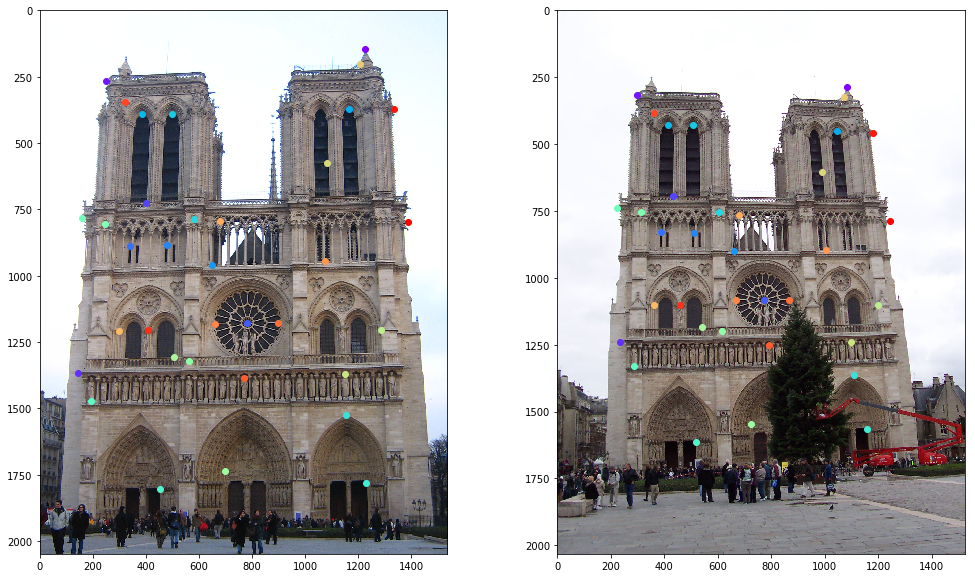

In [76]:
result = prepare_results(desc1, desc2)
r = result.loc[result.groupby('idx')['val1'].idxmin()]
filtered = nndr(result)
print 'number of all features: ', r.shape[0]
print 'positive: ', (r['idx'] == r['idx2']).sum()
print 'score for all features: ', (r['idx'] == r['idx2']).sum() / float(res.shape[0]) * 100, '%'
print
print 'number of filtered features by NNDR: ', filtered.shape[0]
print 'positive: ', (filtered['idx'] == filtered['idx2']).sum() 
print 'score: ', (filtered['idx'] == filtered['idx2']).sum() / float(filtered.shape[0]) * 100, '%'

dd = r[r['idx'] == r['idx2']]
n = len(dd)
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, n))

fig = figure(figsize=(17, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(notre_dame)
ax[1].imshow(notre_dame2)
for (_, rr), c in zip(dd[:n].iterrows(), colors):
    ax[0].scatter(rr['x1'], rr['y1'], color=c)
    ax[1].scatter(rr['x2'], rr['y2'], color=c)

# Task 4 Statistics

In [97]:
def prepare_stats(result, ratio=0.85, info=True):
    result['match_found'] = False
    result.loc[result.ratio < ratio, 'match_found'] = True
    TP = float(result[result.match_found & (result.idx == result.idx2)].shape[0])
    FP = float(result[result.match_found & (result.idx != result.idx2)].shape[0])
    FN = float(result[~result.match_found & (result.idx == result.idx2)].shape[0])
    TN = float(result[~result.match_found & (result.idx != result.idx2)].shape[0])
    if info:
        print 'true positive: ', TP
        print 'false positive: ', FP
        print 'false negative: ', FN
        print 'true negative: ', TN
        print 
        print 'RECALL: ',  TP / (TP + FN)
        print 'FALSE POSITIVE RATE: ',  FP / (FP + TN)
        print 'PRECISION: ',  TP / (TP + FP) 
        print 'ACCURACY: ',  (TP + TN) / result.shape[0]
    return TP, FP, FN, TN

In [111]:
_ = prepare_stats(result, ratio=0.85)

true positive:  21.0
false positive:  7.0
false negative:  76.0
true negative:  419.0

RECALL:  0.216494845361
FALSE POSITIVE RATE:  0.0164319248826
PRECISION:  0.75
ACCURACY:  0.841300191205
